### Mounting your google drive on Colab Noetebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/  


/content/drive/My Drive/unqml/ML_UNQ2020


In [ ]:
#%cd ../

/home/ariel/repos/ML_UNQ2020


In [3]:
import src.utility_functions as uf   ## cargo funciones
# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


## además cargo funciones específicas para este notebook
try:
    import category_encoders as ce
except:
    !pip install category_encoders


from sklearn.model_selection import cross_val_score

## Para guardar y levantar un objeto en pickle (ej. resultados de un gridsearch intensivo)
import joblib as jlb


## Hyperparameter optimization
from sklearn.model_selection import GridSearchCV

try:
    import shap
except:
    !pip install shap
    import shap
from xgboost import XGBClassifier


     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 327kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463914 sha256=3339006549193a4ec35f372aa88193789c312c6d1497d23ea3f93a6d35a09e73
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [4]:
datapath = './data/VariantEffectPrediction/clinvarHC_modeling.csv.gz'
SEED = 2718281
targetcolumn = 'ClinvarHC'
data = pd.read_csv(datapath,sep = ',',index_col='ChrPosRefAlt')
XX,y = data.drop([targetcolumn],axis = 1), data[[targetcolumn]]
X= XX.copy()

#################################
## encoding categorical variables
categorical_feature_mask = XX.dtypes==object       # esto nos da un vector booleano 
categorical_columns = XX.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas

encode_df=XX[categorical_columns].copy()
encode_df = encode_df.astype('str')
encode_df = encode_df.apply(LabelEncoder().fit_transform)  ## puedo agregar una línea para no perder la transformación
X[categorical_columns] = encode_df
#################################





In [5]:
## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=SEED,stratify = y)
Y_train = y_train[targetcolumn].ravel()
Y_test = y_test[targetcolumn].ravel()


In [6]:
model = XGBClassifier()
rfcv = cross_val_score(model, X_train, Y_train, cv=5,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.8732878738859897 0.043137208229059844


In [8]:
#pipeline['clasificador']

In [9]:
pipeline = Pipeline(steps = [('clasificador',XGBClassifier(random_state = SEED,n_estimators = 100,
                                                           scale_pos_weight=Y_train.mean(),eval_metric = 'aucpr' ))])  


In [10]:
name = 'reg_alpha'
value_range = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,100,1000]
#name = 'gamma'
#value_range = np.linspace(0, 0.2, 10, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)


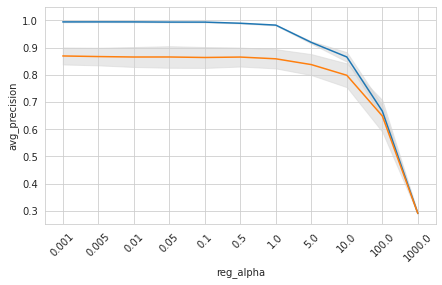

In [11]:
matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

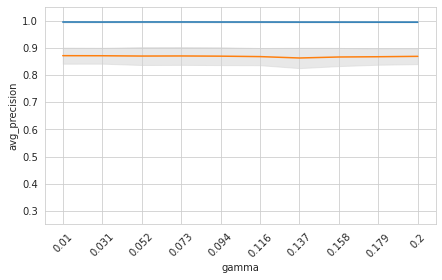

In [12]:
name = 'gamma'
value_range =  np.linspace(0.01, 0.2, 10, endpoint=True)
#name = 'gamma'
#value_range = np.linspace(0, 0.2, 10, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)
matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

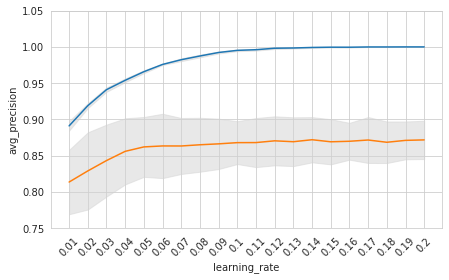

In [13]:
name = 'learning_rate'
value_range =  np.linspace(0.01, 0.2, 20, endpoint=True)
#name = 'gamma'
#value_range = np.linspace(0, 0.2, 10, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)
matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.75,1.05], ylabel= 'avg_precision')

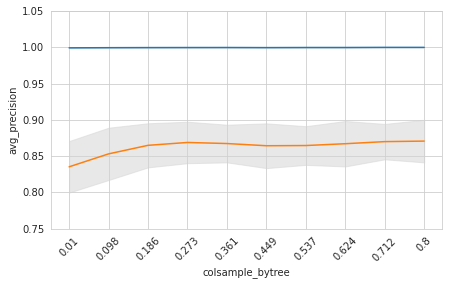

In [14]:
pipeline = Pipeline(steps = [('clasificador',XGBClassifier(random_state = SEED,n_estimators = 500,
                                                           scale_pos_weight=Y_train.mean(),
                                                           eval_metric = 'logloss' ,
                                                          colsample_bynode = 0.3,colsample_bylevel=0.3))])  

name = 'colsample_bytree'
value_range =  np.linspace(0.01, 0.8, 10, endpoint=True)
#name = 'gamma'
#value_range = np.linspace(0, 0.2, 10, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)
matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.75,1.05], ylabel= 'avg_precision')

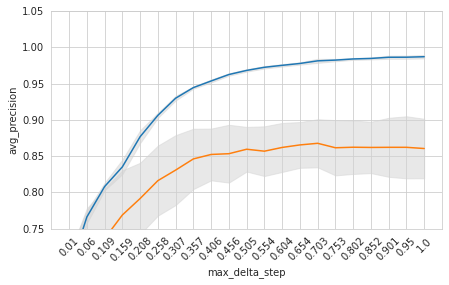

In [18]:
pipeline = Pipeline(steps = [('clasificador',XGBClassifier(random_state = SEED,n_estimators = 100,
                                                           scale_pos_weight=Y_train.mean(),
                                                           eval_metric = 'aucpr' ,
                                                          colsample_bynode = 0.5,colsample_bylevel=0.5))])  

name = 'max_delta_step'
value_range =  np.linspace(0.01, 1, 21, endpoint=True)
#name = 'gamma'
#value_range = [1,5,10,50,100,100]

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)
matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.75,1.05], ylabel= 'avg_precision') 

In [24]:
pipeline.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('clasificador',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.5, colsample_bynode=0.5,
                               colsample_bytree=1, eval_metric='aucpr', gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic',
                               random_state=2718281, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.2901849217638691, seed=None,
                               silent=None, subsample=1, verbosity=1))],
         verbose=False)

In [25]:
metrics.average_precision_score(Y_test,pipeline.predict_proba(X_test)[:,1])

0.8426607405553408

## Bayessian OPT

In [37]:
try:
    import skopt
except:
    !pip install  install scikit-optimize
    import skopt

from skopt.space import Real, Categorical, Integer
# para optimizar vía gaussian process (secuencial). 
from skopt import gp_minimize
from skopt import forest_minimize
from skopt.utils import use_named_args
# para visualizar el gp secuencial
from skopt import plots as skplots


In [38]:
pipeline = Pipeline(steps = [('m',XGBClassifier(random_state = SEED,n_estimators = 500,
                                                           scale_pos_weight=Y_train.mean(),
                                                           eval_metric = 'aucpr' ,
                                                          colsample_bynode = 0.5,colsample_bylevel=0.5))])  
search_space  = [
          Integer(3, 7, name='m__max_depth'),
          Real(1e-4, 3e-1, "uniform", name='m__eta'),
          Real(0.25, 0.75, "uniform", name='m__colsample_bytree'),
          Real(1e-6, 1e0, "log-uniform", name='m__reg_lambda')]

@use_named_args(search_space)
def objective(**params):
    pipeline.set_params(**params)

    return 1.0 - np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'average_precision'))



In [39]:
ncalls = 100
res_gp = gp_minimize(objective, search_space, n_calls=ncalls, random_state=SEED,verbose=True)
jlb.dump(res_gp, 'xgb_gp_minimize_nc100.pkl')

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.7125
Function value obtained: 0.1336
Current minimum: 0.1336
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.0397
Function value obtained: 0.1363
Current minimum: 0.1336
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8364
Function value obtained: 0.1419
Current minimum: 0.1336
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.0289
Function value obtained: 0.1311
Current minimum: 0.1311
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1658
Function value obtained: 0.1421
Current minimum: 0.1311
Iteration No: 6 started. Evaluating

The objective has been evaluated at this point before.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.2036
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.2522
Function value obtained: 0.1296
Current minimum: 0.1286
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.6216
Function value obtained: 0.1299
Current minimum: 0.1286
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.1981
Function value obtained: 0.1295
Current minimum: 0.1286
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.5196
Function value obtained: 0.1299
Current minimum: 0.1286
Iteration No: 21 started. Sea

The objective has been evaluated at this point before.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.2345
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 22 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.1549
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.7270
Function value obtained: 0.1355
Current minimum: 0.1286
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.2349
Function value obtained: 0.1326
Current minimum: 0.1286
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.2500
Function value obtained: 0.1393
Current minimum: 0.1286
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.1922
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 27 started. Sea

The objective has been evaluated at this point before.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.2081
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.0780
Function value obtained: 0.1326
Current minimum: 0.1286
Iteration No: 29 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.2060
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 30 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.2247
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 31 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.2292
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.6377
Function value obtained: 0.1327
Current minimum: 0.1286
Iteration No: 33 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.3166
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.2436
Function value obtained: 0.1338
Current minimum: 0.1286
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.7005
Function value obtained: 0.1379
Current minimum: 0.1286
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.1829
Function value obtained: 0.1338
Current minimum: 0.1286
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.1906
Function value obtained: 0.1326
Current minimum: 0.1286
Iteration No: 38 started. Sea

The objective has been evaluated at this point before.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.3845
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.4055
Function value obtained: 0.1378
Current minimum: 0.1286
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.2442
Function value obtained: 0.1338
Current minimum: 0.1286
Iteration No: 43 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.4469
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 44 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.3761
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.7748
Function value obtained: 0.1321
Current minimum: 0.1286
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.4476
Function value obtained: 0.1392
Current minimum: 0.1286
Iteration No: 47 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.4079
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.2869
Function value obtained: 0.1338
Current minimum: 0.1286
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.7557
Function value obtained: 0.1379
Current minimum: 0.1286
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.3050
Function value obtained: 0.1326
Current minimum: 0.1286
Iteration No: 51 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 1.4487
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 52 started. Searching for the next optimal point.
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 1.3251
Function value obtained: 0.1326
Current minimum: 0.1286
Iteration No: 53 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.5310
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 54 started. Searching for the next optimal point.
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 1.6563
Function value obtained: 0.1336
Current minimum: 0.1286
Iteration No: 55 started. Searching for the next optimal point.
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 1.4112
Function value obtained: 0.1338
Current minimum: 0.1286
Iteration No: 56 started. Searching for the next optimal point.
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 1.4465
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 57 started. Searching for the next optimal point.
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 1.3491
Function value obtained: 0.1326
Current minimum: 0.1286
Iteration No: 58 started. Sea

The objective has been evaluated at this point before.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 1.5220
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 61 started. Searching for the next optimal point.
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 1.4179
Function value obtained: 0.1334
Current minimum: 0.1264
Iteration No: 62 started. Searching for the next optimal point.
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 1.3810
Function value obtained: 0.1338
Current minimum: 0.1264
Iteration No: 63 started. Searching for the next optimal point.
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.5759
Function value obtained: 0.1381
Current minimum: 0.1264
Iteration No: 64 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.6123
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 65 started. Searching for the next optimal point.
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.4286
Function value obtained: 0.1338
Current minimum: 0.1264
Iteration No: 66 started. Searching for the next optimal point.
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.6001
Function value obtained: 0.1312
Current minimum: 0.1264
Iteration No: 67 started. Searching for the next optimal point.
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.8423
Function value obtained: 0.1336
Current minimum: 0.1264
Iteration No: 68 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.6232
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 69 started. Searching for the next optimal point.
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.9395
Function value obtained: 0.1327
Current minimum: 0.1264
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.7992
Function value obtained: 0.1358
Current minimum: 0.1264
Iteration No: 71 started. Searching for the next optimal point.
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.5323
Function value obtained: 0.1301
Current minimum: 0.1264
Iteration No: 72 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.6590
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 73 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.6357
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 74 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.7481
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 75 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.6772
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 76 started. Searching for the next optimal point.
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.7314
Function value obtained: 0.1361
Current minimum: 0.1264
Iteration No: 77 started. Searching for the next optimal point.
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.9357
Function value obtained: 0.1284
Current minimum: 0.1264
Iteration No: 78 started. Searching for the next optimal point.
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.9889
Function value obtained: 0.1345
Current minimum: 0.1264
Iteration No: 79 started. Searching for the next optimal point.
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 2.1595
Function value obtained: 0.1336
Current minimum: 0.1264
Iteration No: 80 started. Sea

The objective has been evaluated at this point before.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.7277
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 83 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.8422
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 2.1283
Function value obtained: 0.1318
Current minimum: 0.1264
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 2.3139
Function value obtained: 0.1349
Current minimum: 0.1264
Iteration No: 86 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.8080
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 87 started. Searching for the next optimal point.
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 2.0521
Function value obtained: 0.1321
Current minimum: 0.1264
Iteration No: 88 started. Searching for the next optimal point.
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.9116
Function value obtained: 0.1361
Current minimum: 0.1264
Iteration No: 89 started. Searching for the next optimal point.
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 2.0139
Function value obtained: 0.1397
Current minimum: 0.1264
Iteration No: 90 started. Searching for the next optimal point.
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 2.4165
Function value obtained: 0.1318
Current minimum: 0.1264
Iteration No: 91 started. Sea

The objective has been evaluated at this point before.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.9948
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 93 started. Searching for the next optimal point.
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 2.3004
Function value obtained: 0.1347
Current minimum: 0.1264
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 2.3073
Function value obtained: 0.1341
Current minimum: 0.1264
Iteration No: 95 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 2.0576
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 96 started. Searching for the next optimal point.
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 2.1517
Function value obtained: 0.1421
Current minimum: 0.1264
Iteration No: 97 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 2.1186
Function value obtained: 0.1286
Current minimum: 0.1264
Iteration No: 98 started. Searching for the next optimal point.
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 2.3478
Function value obtained: 0.1361
Current minimum: 0.1264
Iteration No: 99 started. Searching for the next optimal point.
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 2.5347
Function value obtained: 0.1357
Current minimum: 0.1264
Iteration No: 100 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 2.1326
Function value obtained: 0.1286
Current minimum: 0.1264


['xgb_gp_minimize_nc100.pkl']

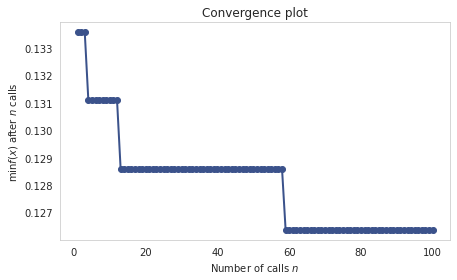

In [40]:
res = res_gp
skplots.plot_convergence(res)

In [41]:
for i in range(len(res.x)):
    pipeline.set_params(**{search_space[i].name:res.x[i]})
pipeline.named_steps['m']

np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'average_precision'))

0.873632105884289

In [42]:
pipeline = pipeline.fit(X_train,Y_train)
metrics.average_precision_score(Y_test,pipeline.predict_proba(X_test)[:,1])

0.8425050421807743

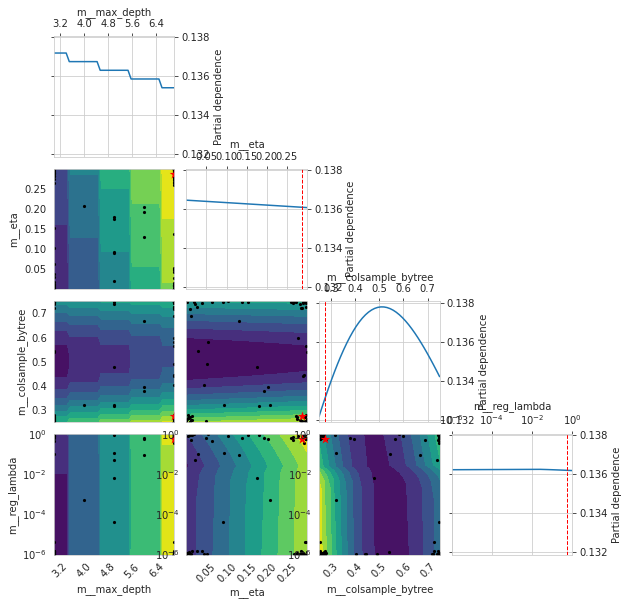

In [43]:
from skopt.plots import  plot_objective
_ = plot_objective(res)

In [44]:
pipeline = Pipeline(steps = [('m',XGBClassifier(random_state = SEED,n_estimators = 1000,
                                                           scale_pos_weight=Y_train.mean(),
                                                           eval_metric = 'aucpr' ,
                                                          colsample_bynode = 0.5,colsample_bylevel=0.5))])  
search_space  = [
          Integer(3, 10, name='m__max_depth'),
          Real(1e-4, 3e-1, "uniform", name='m__eta'),
          Real(0.1, 0.9, "uniform", name='m__colsample_bytree'),
#          Real(0.01, 1, "uniform", name='m__reg_lambda'),
          Real(0.1, 1, "uniform", name='m__subsample'),
          Real(0, 0.2, "uniform", name='m__gamma')

]

@use_named_args(search_space)
def objective(**params):
    pipeline.set_params(**params)

    return 1.0 - np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'average_precision'))



In [45]:
?model

In [46]:
ncalls = 75
res_gp50 = gp_minimize(objective, search_space, n_calls=ncalls, random_state=SEED,verbose=True)
jlb.dump(res_gp50, 'xgb_gp_minimize_nc75.pkl')

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.4638
Function value obtained: 0.1387
Current minimum: 0.1387
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.6916
Function value obtained: 0.1624
Current minimum: 0.1387
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.1585
Function value obtained: 0.1426
Current minimum: 0.1387
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.9246
Function value obtained: 0.1334
Current minimum: 0.1334
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.3767
Function value obtained: 0.1296
Current minimum: 0.1296
Iteration No: 6 started. Evaluating

The objective has been evaluated at this point before.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.4415
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 27 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.3964
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.2480
Function value obtained: 0.1390
Current minimum: 0.1286
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.7014
Function value obtained: 0.1320
Current minimum: 0.1286
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.6643
Function value obtained: 0.1288
Current minimum: 0.1286
Iteration No: 31 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 3.4019
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 32 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 3.4607
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 2.0588
Function value obtained: 0.1322
Current minimum: 0.1286
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 3.0838
Function value obtained: 0.1546
Current minimum: 0.1286
Iteration No: 35 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 3.6724
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.8063
Function value obtained: 0.1537
Current minimum: 0.1286
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.9668
Function value obtained: 0.1431
Current minimum: 0.1286
Iteration No: 38 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 2.9555
Function value obtained: 0.1303
Current minimum: 0.1286
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.8911
Function value obtained: 0.1424
Current minimum: 0.1286
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.5396
Function value obtained: 0.1876
Current minimum: 0.1286
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.7334
Function value obtained: 0.1423
Current minimum: 0.1286
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.8348
Function value obtained: 0.1397
Current minimum: 0.1286
Iteration No: 43 started. Sea

The objective has been evaluated at this point before.


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.5694
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.0156
Function value obtained: 0.1438
Current minimum: 0.1286
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.9822
Function value obtained: 0.1415
Current minimum: 0.1286
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 3.0029
Function value obtained: 0.1389
Current minimum: 0.1286
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 2.1126
Function value obtained: 0.1521
Current minimum: 0.1286
Iteration No: 48 started. Sea

The objective has been evaluated at this point before.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 3.6470
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 50 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 3.9256
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 51 started. Searching for the next optimal point.
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 3.7628
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 52 started. Searching for the next optimal point.
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 2.2115
Function value obtained: 0.1435
Current minimum: 0.1286
Iteration No: 53 started. Searching for the next optimal point.
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 2.1758
Function value obtained: 0.1362
Current minimum: 0.1286
Iteration No: 54 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 3.7475
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 55 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 3.7826
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 56 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 3.8138
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 57 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 3.7758
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 58 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 3.7299
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 59 started. Searching for the next optimal point.
Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 3.3803
Function value obtained: 0.1525
Current minimum: 0.1286
Iteration No: 60 started. Searching for the next optimal point.
Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 3.7792
Function value obtained: 0.1345
Current minimum: 0.1286
Iteration No: 61 started. Searching for the next optimal point.
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 2.0295
Function value obtained: 0.1416
Current minimum: 0.1286
Iteration No: 62 started. Searching for the next optimal point.
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 3.1434
Function value obtained: 0.1405
Current minimum: 0.1286
Iteration No: 63 started. Sea

The objective has been evaluated at this point before.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 3.8489
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 67 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 3.8406
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 68 started. Searching for the next optimal point.
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 2.1190
Function value obtained: 0.1445
Current minimum: 0.1286
Iteration No: 69 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 3.8901
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 2.2353
Function value obtained: 0.1459
Current minimum: 0.1286
Iteration No: 71 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 3.9773
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 72 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 3.9827
Function value obtained: 0.1286
Current minimum: 0.1286
Iteration No: 73 started. Searching for the next optimal point.
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 2.4402
Function value obtained: 0.1311
Current minimum: 0.1286
Iteration No: 74 started. Searching for the next optimal point.
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 2.3707
Function value obtained: 0.1404
Current minimum: 0.1286
Iteration No: 75 started. Searching for the next optimal point.
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 3.5532
Function value obtained: 0.1412
Current minimum: 0.1286


['xgb_gp_minimize_nc75.pkl']

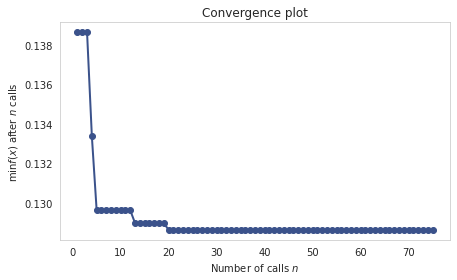

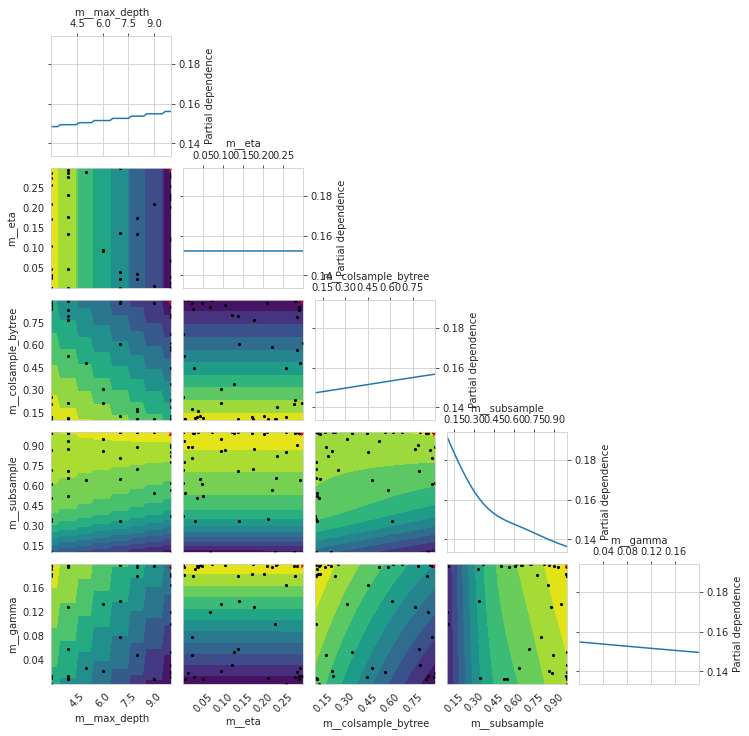

In [47]:
res = res_gp50
skplots.plot_convergence(res)
_ = plot_objective(res)

In [48]:
?model